***
## notebook config

In [1]:
ON_COLAB = False
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade tsforest > /dev/null 2>&1
    !pip install --upgrade lightgbm > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)

input_path: ../data
subs_path: ../subs
results_path: ../results


In [4]:
SEED = 19
SUB_NBR = "12"

***

In [5]:
from copy import deepcopy
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from tqdm import tqdm
import yaml

import category_encoders as ce
import lightgbm as lgb
from tsforest.forecast import LightGBMForecaster

import sys
sys.path.append("../utils")
from memory import reduce_mem_usage
from metrics import RMSSE, ranked_probability_score, scoring_function, binarize_predictions
from inventory import InventoryDaysPredictor

np.random.seed(SEED)
pd.set_option('display.max_columns', None)

***
## loading data for assessment

In [6]:
if ASSESS:
    scales = pd.read_csv(f"{input_path}/scales.csv")
    skus_for_test = pd.read_csv(f"{input_path}/test_data.csv").sku.values
    skus_for_assess = pd.read_csv(f"{input_path}/skus_for_assess.csv").sku.values
    print("# skus test:", len(skus_for_test))
    print("# skus assess:", len(skus_for_assess))
    
    skus_for_assess = set(skus_for_assess) & set(skus_for_test)
    print("# skus assess & test:", len(skus_for_assess))

    dataset = (
        pd.read_parquet(f"{input_path}/train.parquet")
        .query("sku in @skus_for_assess")
        .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
        .sort_values(["sku","ds"])
        .reset_index(drop=True)
    )
    dataset

# skus test: 551472
# skus assess: 496797
# skus assess & test: 421636


In [7]:
with open(f"../config/dist_hparams.yml", "r") as file:
    dist_config = yaml.load(file, Loader=yaml.FullLoader)
    file.close()
dist_config

{'beta': 0.5607622708084541,
 'corr_factor': 1.2025296178014329,
 'lambda1': 0.5476473565886333,
 'lambda2': 0.8678989339789255}

In [8]:
with open(f"../data/skus_assess_m2.yaml", "r") as file:
    skus_assess_m2 = yaml.load(file, Loader=yaml.FullLoader)
    print(len(skus_assess_m2))
    file.close()

272130


***
## model config

In [9]:
categorical_features = {
    "sku": ("y", ce.CatBoostEncoder, None),
    "currency": "default",
    "listing_type": "default",
    "shipping_logistic_type": "default",
    "shipping_payment": "default",
    "item_domain_id": "default",
    "item_id": ("y", ce.CatBoostEncoder, None),
    "site_id":"default",
    "product_id": ("y", ce.CatBoostEncoder, None),
    "product_family_id": ("y", ce.CatBoostEncoder, None),
}

exclude_features = ["fold","sold_quantity",]

model_params = {
    'objective':'tweedie',
    'tweedie_variance_power':1.6,
    'metric':'None',
    'num_iterations':1000,
    'max_bin': 63,
    'bin_construct_sample_cnt':20000000,
    'num_leaves': 2**8-1,
    'min_data_in_leaf': 2**8-1,
    'learning_rate': 0.02,
    'max_delta_step':1.,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'max_cat_threshold': 64,
    'cat_l2': 50,
    'cat_smooth': 50,
    'boost_from_average': False,
    'force_row_wise': True,
    'deterministic':True,
    'seed':SEED,
}
time_features = [
    "week_day",
    "week_day_cos",
    "week_day_sin",
    "month_progress",
]
model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "exclude_features":exclude_features,
    "categorical_features":categorical_features,
    "ts_uid_columns":["sku",],
    "lags": [1,],
    "window_functions":{
        "mean":   (None, [1,], [3,5,7,]),
        "std":    (None, [1,], [3,5,7]),
    },
}

***
## model training: assessment

------------------------------------------------------------------------------------------
Preparing model for site: MLA
Mem. usage decreased to 98.21 Mb (51.7% reduction)
Mem. usage decreased to 102.65 Mb (51.7% reduction)
Elapsed time for processing features: 0.4661298672358195 min.
[LightGBM] [Info] Total Bins 2488
[LightGBM] [Info] Number of data points in the train set: 1061623, number of used features: 21
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.820525
[100]	valid_0's rmsse: 0.776953
[150]	valid_0's rmsse: 0.772671
Early stopping, best iteration is:
[145]	valid_0's rmsse: 0.77263


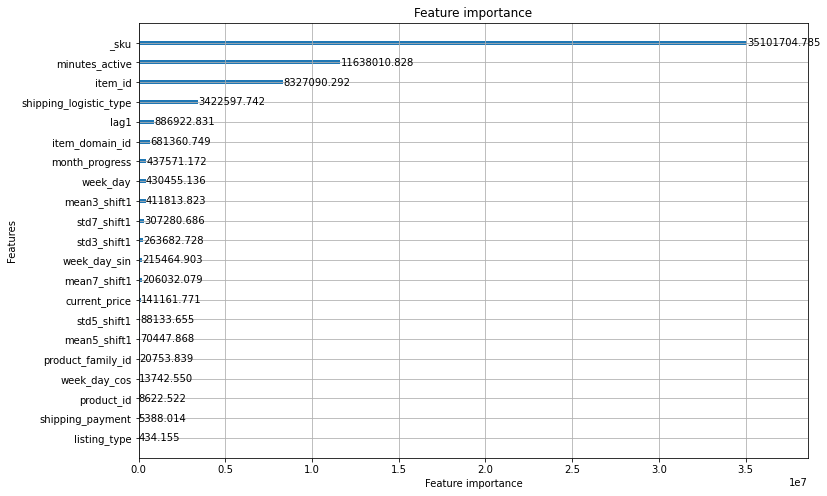

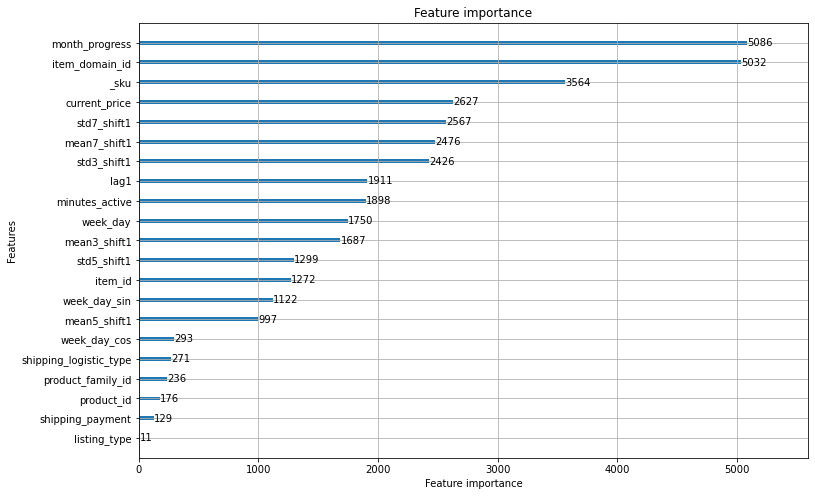

Elapsed time for training the model: 1.066939385732015 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLB
Mem. usage decreased to 569.87 Mb (51.7% reduction)
Mem. usage decreased to 593.50 Mb (51.7% reduction)
Elapsed time for processing features: 4.4988755822181705 min.
[LightGBM] [Info] Total Bins 3107
[LightGBM] [Info] Number of data points in the train set: 6160383, number of used features: 21
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.863451
[100]	valid_0's rmsse: 0.812349
[150]	valid_0's rmsse: 0.805425
[200]	valid_0's rmsse: 0.805086
Early stopping, best iteration is:
[184]	valid_0's rmsse: 0.804912


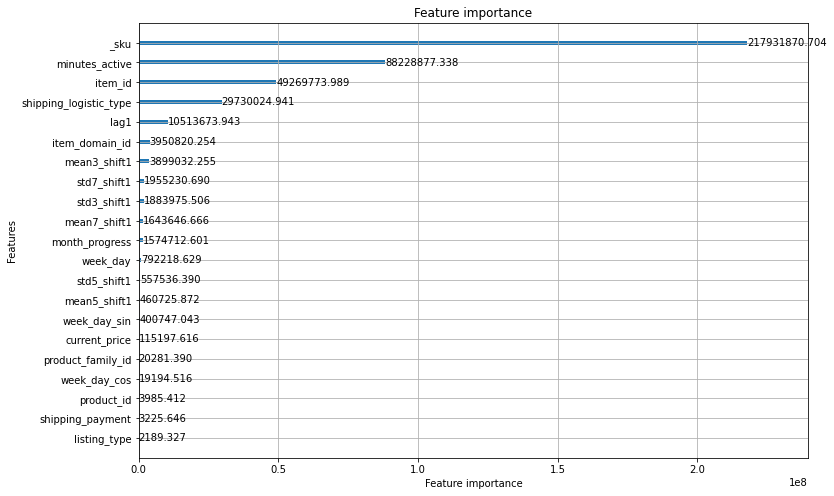

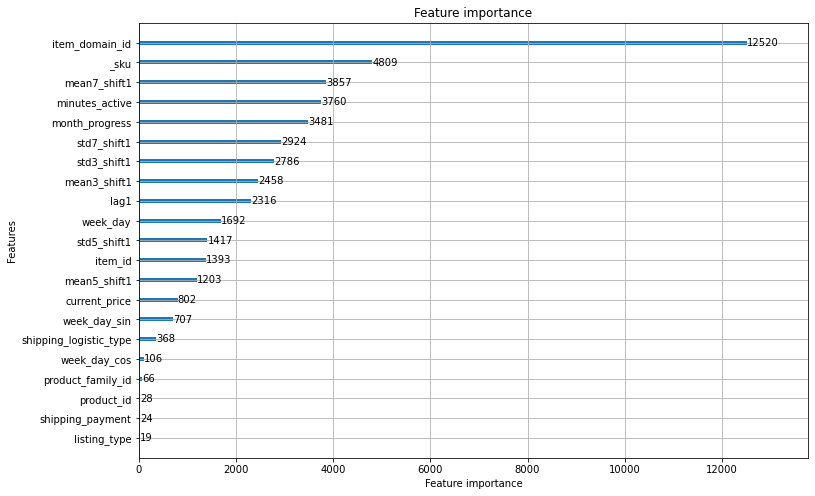

Elapsed time for training the model: 6.02849634885788 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLM
Mem. usage decreased to 453.14 Mb (51.7% reduction)
Mem. usage decreased to 473.97 Mb (51.7% reduction)
Elapsed time for processing features: 4.756988994280497 min.
[LightGBM] [Info] Total Bins 2991
[LightGBM] [Info] Number of data points in the train set: 4898512, number of used features: 21
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.822388
[100]	valid_0's rmsse: 0.772518
[150]	valid_0's rmsse: 0.766215
[200]	valid_0's rmsse: 0.766201
Early stopping, best iteration is:
[181]	valid_0's rmsse: 0.76584


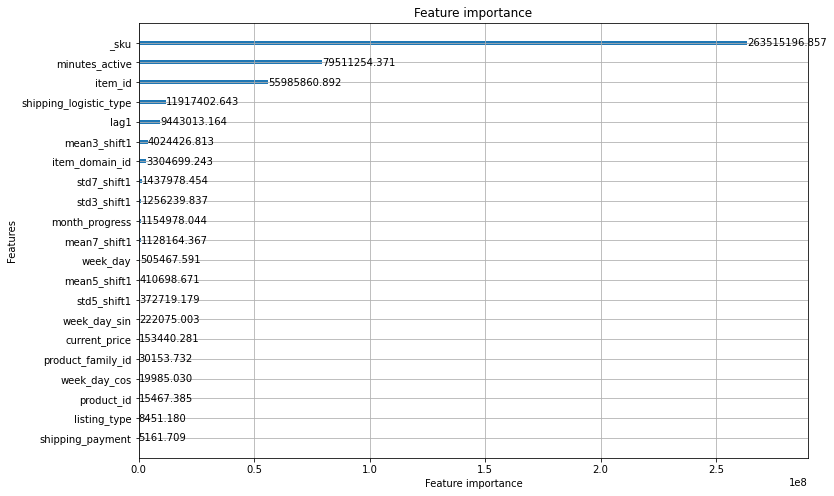

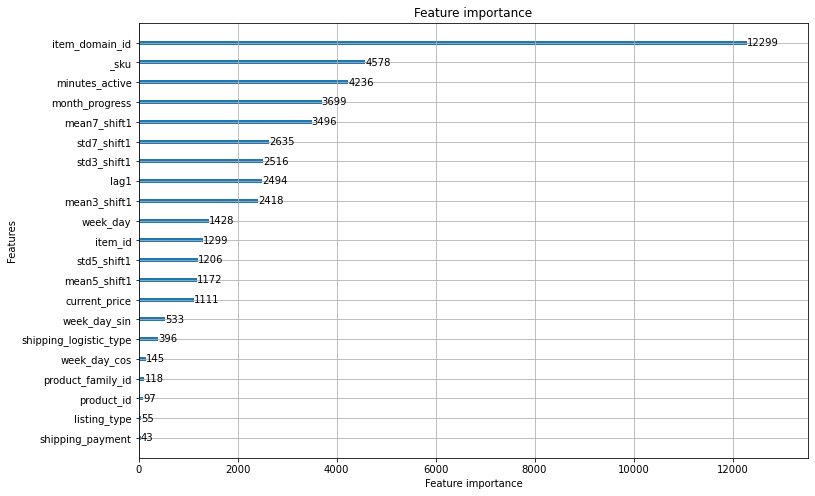

Elapsed time for training the model: 4.4200424154599505 min.


{'rmsse_MLA': 0.7726300579879929,
 'rmsse_MLB': 0.8049119314511329,
 'rmsse_MLM': 0.7658404999729234,
 'rmsse_AVG': 0.781127496470683}

In [10]:
if ASSESS:
    models_by_site = list()
    sites = ["MLA","MLB","MLM"]

    for site in sites:
        print("-"*90)
        print(f"Preparing model for site: {site}")

        tic = time.time()
        train_data = dataset.query("site_id == @site").reset_index(drop=True)
        valid_idx = train_data.query("ds > '2021-03-01'").index

        model = LightGBMForecaster(**model_kwargs)
        model.prepare_features(train_data, valid_idx)
        model.train_features = reduce_mem_usage(model.train_features, verbose=True)
        model.valid_features = reduce_mem_usage(model.valid_features, verbose=True)
        gc.collect()
        tac = time.time()
        print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

        tic = time.time()
        evaluator = RMSSE(train_data.loc[valid_idx, ["sku","y"]], scales)
        model.fit(fit_kwargs={"verbose_eval":50, "feval":evaluator.evaluate})
        lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="gain")
        lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="split")
        plt.show()
        models_by_site.append(model)
        tac = time.time()
        print(f"Elapsed time for training the model: {(tac-tic)/60} min.")

    errors = list()
    sites = ["MLA","MLB","MLM"]
    for site,model in zip(sites,models_by_site):
        error = model.model.model.best_score["valid_0"]["rmsse"]
        errors.append(error)
    result = {
        "rmsse_MLA":errors[0], 
        "rmsse_MLB":errors[1],
        "rmsse_MLM":errors[2],
        "rmsse_AVG":np.mean(errors),
    }
    display(result)

In [11]:
%%time
if ASSESS:
    all_preds = list()
    for site,model in zip(sites,models_by_site):
        print("Preds for site:", site)
        preds = model.predict(dataset.query("site_id==@site & ds>'2021-03-01'"), recursive=True)
        all_preds.append(preds)
    oof = pd.concat(all_preds, axis=0, ignore_index=True)

Preds for site: MLA
Preds for site: MLB
Preds for site: MLM
CPU times: user 27min 11s, sys: 1min 23s, total: 28min 34s
Wall time: 53min 23s


In [12]:
if ASSESS:
    mrg = pd.merge(oof, dataset.loc[:,["ds","sku","site_id","y"]], how="inner", on=["ds","sku"])
    mrg["sq_error"] = mrg.eval("(y-y_pred)**2")
    valid_errors = np.sqrt(mrg.groupby(["sku","site_id"])["sq_error"].mean()).reset_index(name="rmse")
    valid_errors = pd.merge(valid_errors, scales, how="inner", on="sku")
    valid_errors["rmsse"] = valid_errors.eval("rmse/scale")
    display(valid_errors.groupby("site_id")["rmsse"].mean())

site_id
MLA    0.779798
MLB    0.819613
MLM    0.782378
Name: rmsse, dtype: float64

In [13]:
if ASSESS:
    oof.to_csv(f"{results_path}/oof_preds_lgbm-m1.csv", index=False)

***
## Assessment of invetory days prediction

In [16]:
if ASSESS:
    if "oof" not in locals():
        oof = pd.read_csv("../results/oof_preds_lgbm-m1.csv")
        
    predictor = InventoryDaysPredictor(dataset.query("ds <= '2021-03-01'"))
    predictor.fit(oof)

100%|██████████| 421636/421636 [00:58<00:00, 7247.03it/s]


In [17]:
if ASSESS:
    valid = (
        pd.read_csv(f"{input_path}/validation_realstock.csv")
        .query("sku in @skus_for_assess")
        .reset_index(drop=True)
    )

    preds = list()
    for sku,df in tqdm(valid.groupby("sku")):
        preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
        
    valid["days_to_stockout"] = np.asarray(preds)

100%|██████████| 421636/421636 [00:54<00:00, 7718.98it/s]


RMSE (mean):  8.924733020394171
MAE (mean):  6.24727840057845
MAE (median):  4.0


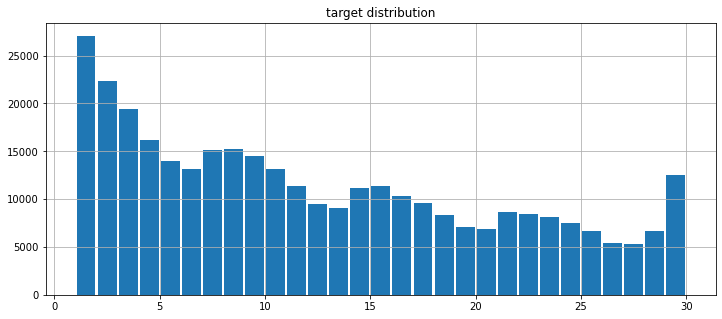

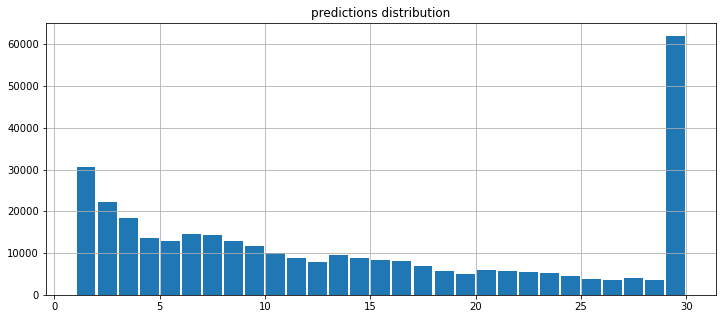

In [18]:
if ASSESS:
    print("RMSE (mean): ", np.sqrt(valid.query("inventory_days <= 31").eval("(days_to_stockout - inventory_days)**2").mean()) )
    print("MAE (mean): ",  valid.query("inventory_days <= 31").eval("abs(days_to_stockout - inventory_days)").mean() )
    print("MAE (median): ", valid.query("inventory_days <= 31").eval("abs(days_to_stockout - inventory_days)").median() )
    
    plt.figure(figsize=(12,5))
    plt.hist(valid.query("inventory_days <= 31").inventory_days, bins=np.arange(1,31,1), rwidth=0.9)
    plt.title(f"target distribution")
    plt.grid()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.hist(valid.query("inventory_days <= 31").days_to_stockout, bins=np.arange(1,31,1), rwidth=0.9)
    plt.title(f"predictions distribution")
    plt.grid()
    plt.show()

RMSE (mean):  7.727806921224162
MAE (mean):  5.26436434107619
MAE (median):  3.2631696703376543


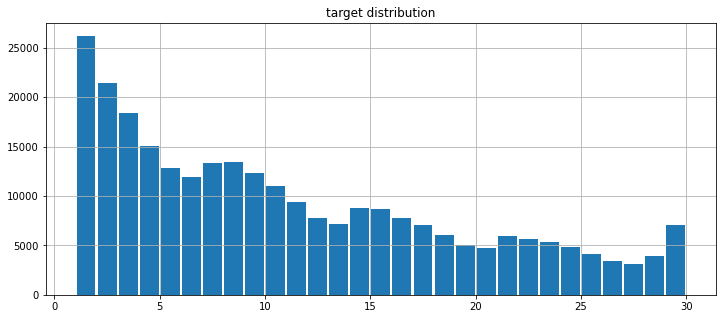

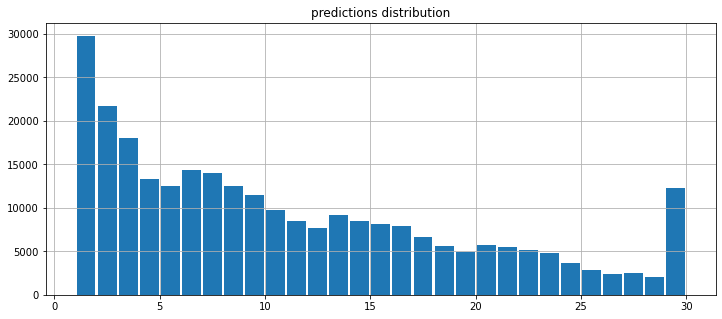

In [19]:
if ASSESS:
    print("RMSE (mean): ", np.sqrt(valid.query("sku in @skus_assess_m2").eval("(days_to_stockout - inventory_days)**2").mean()) )
    print("MAE (mean): ",  valid.query("sku in @skus_assess_m2").eval("abs(days_to_stockout - inventory_days)").mean() )
    print("MAE (median): ", valid.query("sku in @skus_assess_m2").eval("abs(days_to_stockout - inventory_days)").median() )
    
    plt.figure(figsize=(12,5))
    plt.hist(valid.query("sku in @skus_assess_m2").inventory_days, bins=np.arange(1,31,1), rwidth=0.9)
    plt.title(f"target distribution")
    plt.grid()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.hist(valid.query("sku in @skus_assess_m2").days_to_stockout, bins=np.arange(1,31,1), rwidth=0.9)
    plt.title(f"predictions distribution")
    plt.grid()
    plt.show()

***
## Assessment of RPS

In [33]:
# dist config from sub04
dist_config = {
    "beta": 0.634505,
    "lambda1": 0.458712,
    "lambda2": 0.967726,
}

In [34]:
if ASSESS:
    valid_files = [fn for fn in glob(f"{input_path}/validation_*.csv") if "seed2.csv" not in fn]
    results = list()

    for files in valid_files:
        valid = (
            pd.read_csv(files)
            .query("sku in @skus_for_assess")
            .query("inventory_days <= 30")
            .reset_index(drop=True)
        )
        valid["inventory_days"] = valid["inventory_days"].astype(int)
        
        preds_proba = list()
        for sku,df in tqdm(valid.groupby("sku")):
            preds_proba.append(predictor.predict_proba(
                sku, 
                stock=df.target_stock.values[0],
                dist_kwargs={"beta":dist_config["beta"]},
                lambda1=dist_config["lambda1"], 
                lambda2=dist_config["lambda2"],
            ))
        preds_proba = np.array(preds_proba)

        rps = scoring_function(valid.inventory_days.values, preds_proba)
        results.append({"file":files.split("/")[-1].split(".")[0], "rps":rps})
        print({"file":files.split("/")[-1].split(".")[0], "rps":rps})

100%|██████████| 421636/421636 [02:04<00:00, 3393.39it/s]


{'file': 'validation_seed19', 'rps': 3.9204246373413087}


100%|██████████| 421636/421636 [01:57<00:00, 3579.51it/s]


{'file': 'validation_seed23', 'rps': 3.921520710048525}


100%|██████████| 334227/334227 [01:33<00:00, 3579.27it/s]


{'file': 'validation_realstock', 'rps': 3.60366909180371}


100%|██████████| 421636/421636 [01:56<00:00, 3606.26it/s]


{'file': 'validation_seed17', 'rps': 3.921663217423805}


In [35]:
if ASSESS:
    display(pd.DataFrame(results))
    
    # cleanup ram
    del models_by_site
    gc.collect()

,file,rps
0,validation_seed19,3.920425
1,validation_seed23,3.921521
2,validation_realstock,3.603669
3,validation_seed17,3.921663


***
## model training

In [36]:
unpredictable = pd.read_csv(f"{input_path}/unpredictable.csv")
skus_for_test = pd.read_csv(f"{input_path}/test_data.csv").sku.values

dataset = (
    pd.read_parquet(f"{input_path}/train.parquet")
    .query("sku not in @unpredictable.sku")
    .query("sku in @skus_for_test")
    .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
print("nrows:", len(dataset)/1e6)
print("nskus:", dataset.sku.nunique())

nrows: 30.218544
nskus: 526189


In [37]:
test = (
    pd.read_parquet(f"{input_path}/test.parquet")
    .query("sku not in @unpredictable.sku")
    .rename({"date":"ds",}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
print("nrows:", len(test)/1e6)
print("nskus:", test.sku.nunique())

nrows: 15.78567
nskus: 526189


------------------------------------------------------------------------------------------
Preparing model for site: MLA
Mem. usage decreased to 242.55 Mb (51.7% reduction)
Elapsed time for processing features: 0.6720186471939087 min.
[LightGBM] [Info] Total Bins 2554
[LightGBM] [Info] Number of data points in the train set: 2621983, number of used features: 21


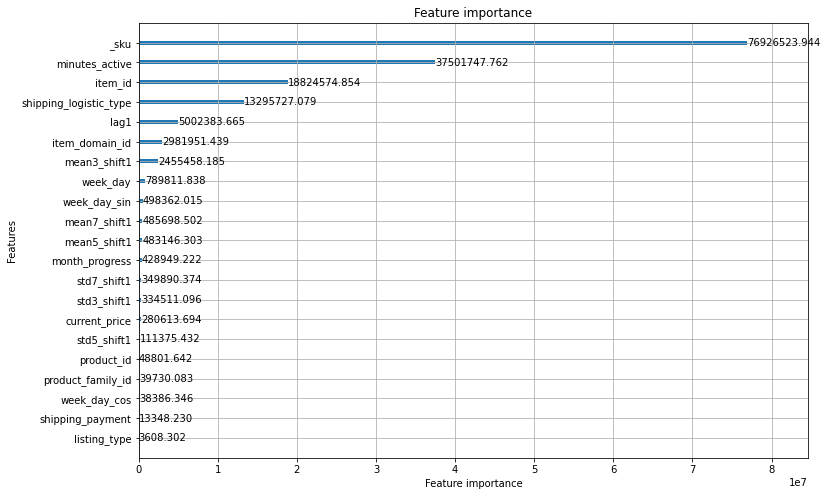

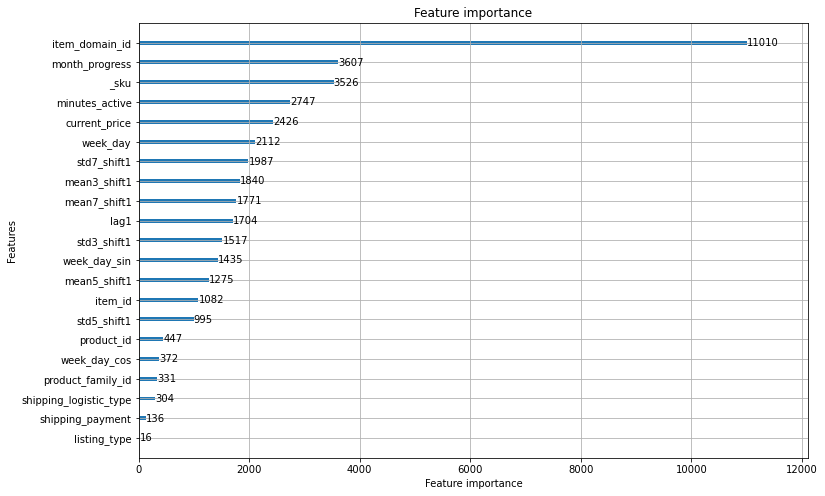

Elapsed time for training the model: 0.4014785051345825 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLB
Mem. usage decreased to 1461.17 Mb (50.7% reduction)
Elapsed time for processing features: 3.7581980506579082 min.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Total Bins 3162
[LightGBM] [Info] Number of data points in the train set: 15476240, number of used features: 21


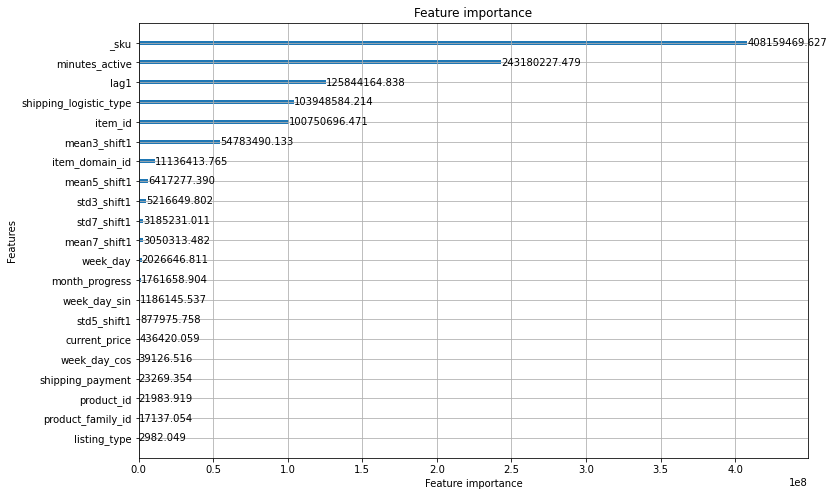

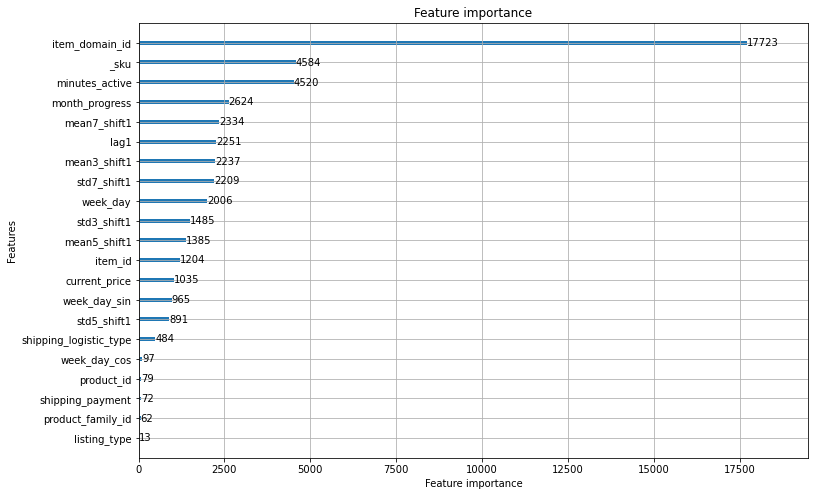

Elapsed time for training the model: 2.6186973492304486 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLM
Mem. usage decreased to 1121.21 Mb (51.7% reduction)
Elapsed time for processing features: 2.9730260650316875 min.
[LightGBM] [Info] Total Bins 3035
[LightGBM] [Info] Number of data points in the train set: 12120321, number of used features: 21


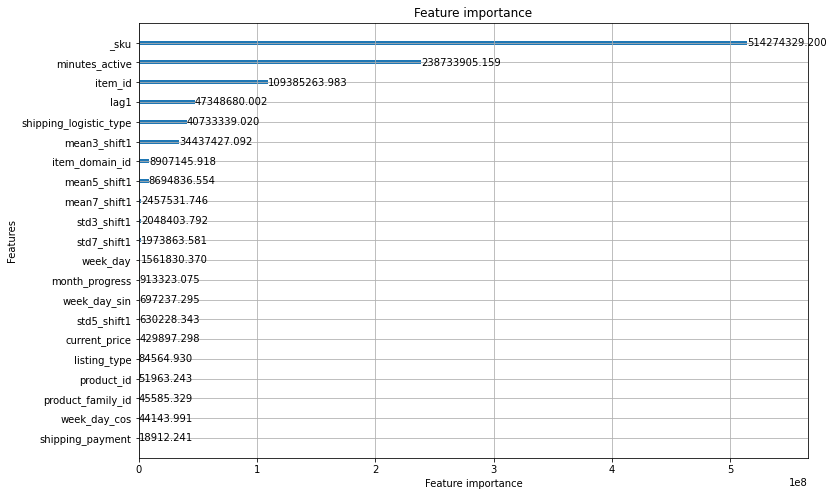

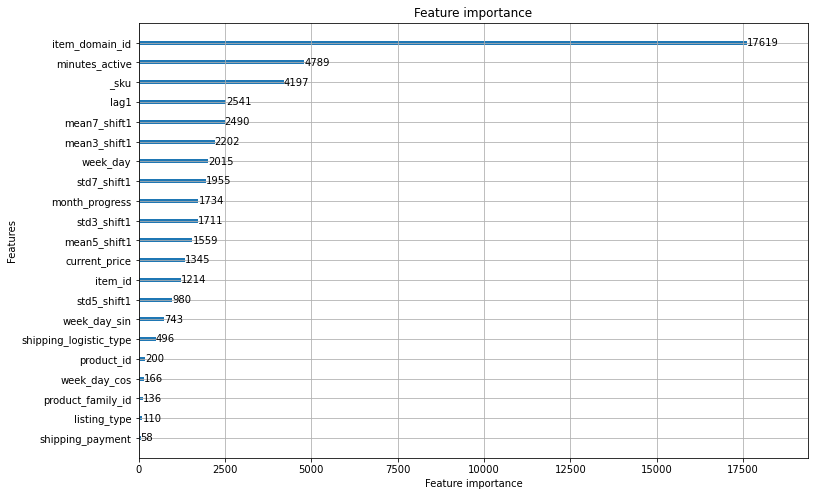

Elapsed time for training the model: 1.9991577029228211 min.


In [38]:
models_by_site = list()
sites = [
    "MLA",
    "MLB",
    "MLM",
]
num_iterations = {
    "MLA": 160,
    "MLB": 190,
    "MLM": 190,
}

for site in sites:
    print("-"*90)
    print(f"Preparing model for site: {site}")

    tic = time.time()
    train_data = dataset.query("site_id == @site").reset_index(drop=True)
    
    _model_kwargs = dict(model_kwargs)
    _model_kwargs["model_params"]["num_iterations"] = num_iterations[site]

    model = LightGBMForecaster(**_model_kwargs)
    model.prepare_features(train_data)
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

    tic = time.time()
    model.fit()
    lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="gain")
    lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="split")
    plt.show()
    models_by_site.append(model)
    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")


In [39]:
preds_by_site = list()

for site,model in tqdm(zip(sites,models_by_site)):
    preds = model.predict(test.query("site_id == @site"), recursive=True)
    preds_by_site.append(preds)

3it [35:04, 701.60s/it]


In [40]:
predictions = pd.concat(preds_by_site, ignore_index=True)
predictions.to_csv(f"../results/preds_m1_lgbm_sub{SUB_NBR}.csv", index=False)

In [41]:
predictor = InventoryDaysPredictor(dataset)
predictor.fit(predictions)

100%|██████████| 526189/526189 [01:10<00:00, 7515.03it/s]


100%|██████████| 526189/526189 [01:06<00:00, 7862.67it/s]


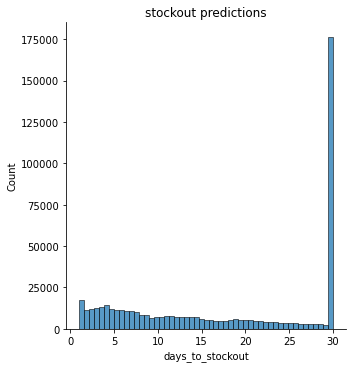

In [42]:
stockout_preds = list()
groups = (
    test[["sku","target_stock"]]
    .drop_duplicates()
    .groupby("sku")
)

for sku,df in tqdm(groups):
    stockout_preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
stockout_preds = pd.DataFrame(stockout_preds, columns=["days_to_stockout"])

sns.displot(stockout_preds.days_to_stockout)
plt.title("stockout predictions")
plt.show()

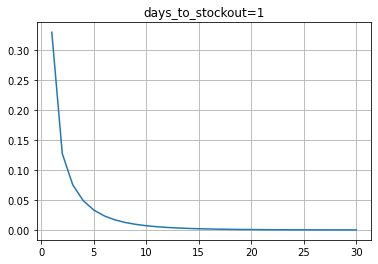

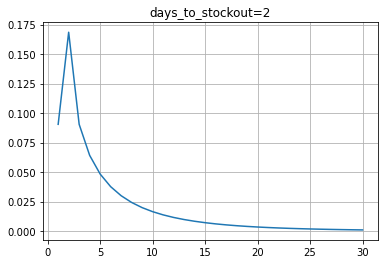

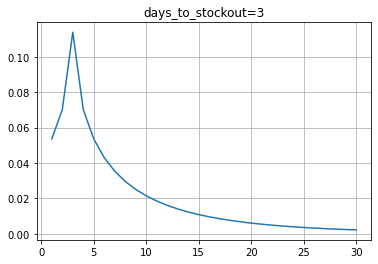

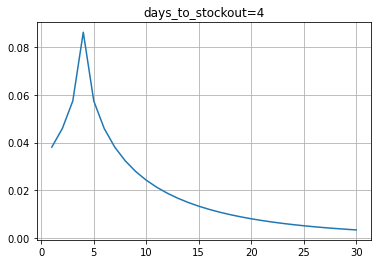

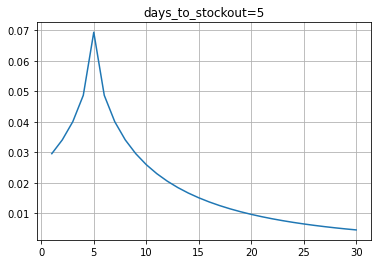

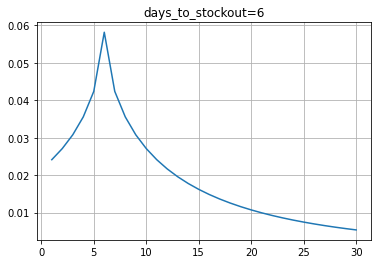

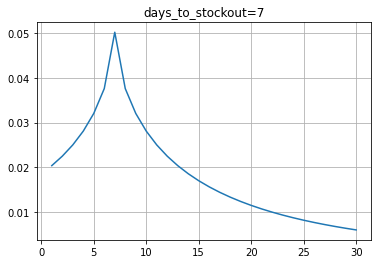

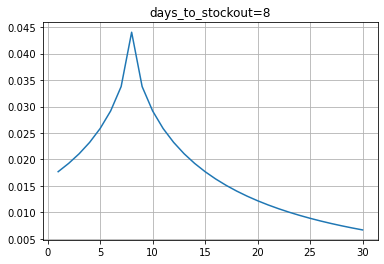

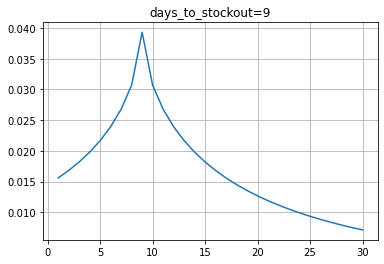

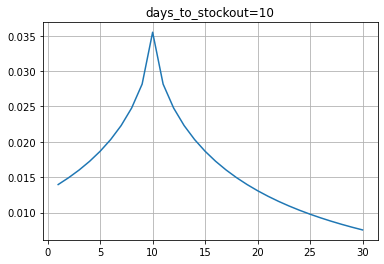

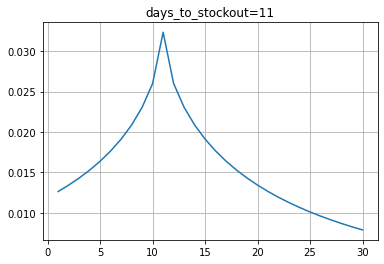

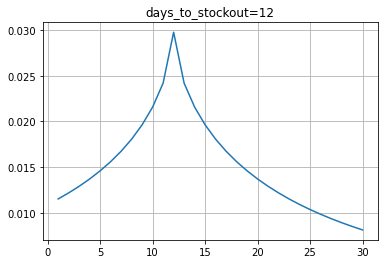

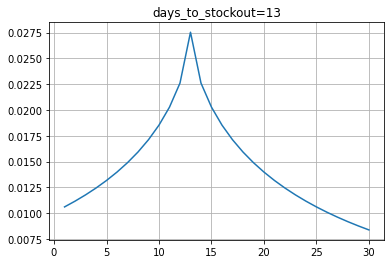

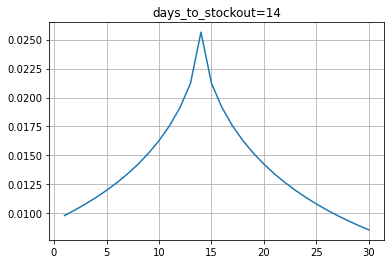

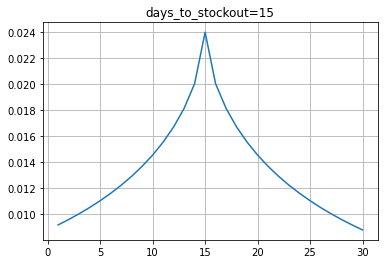

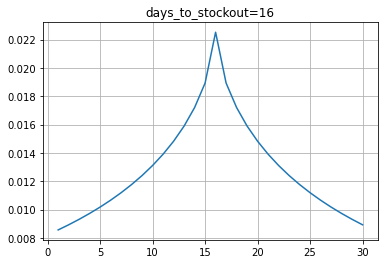

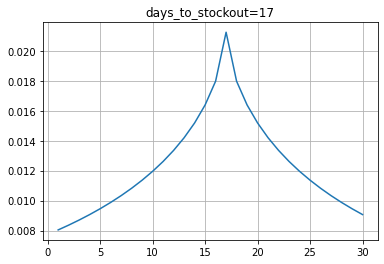

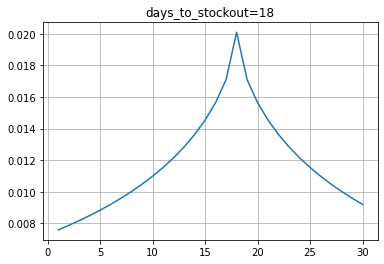

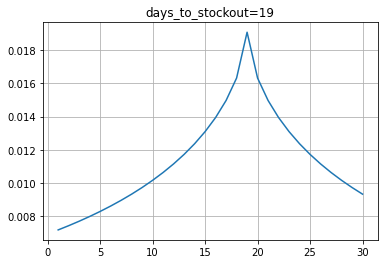

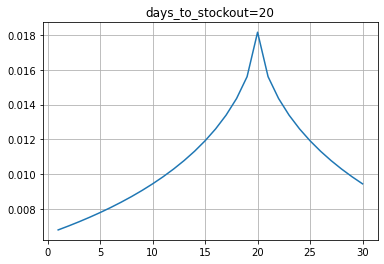

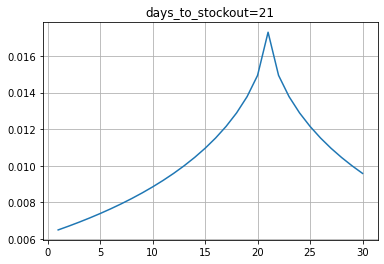

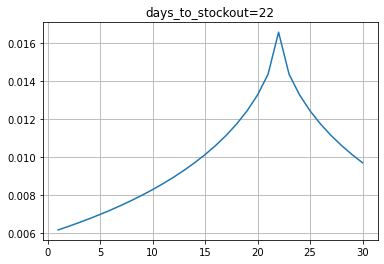

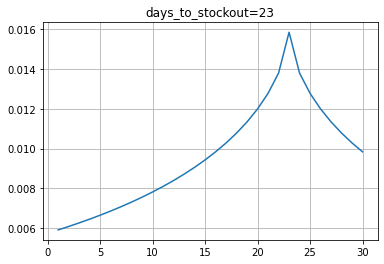

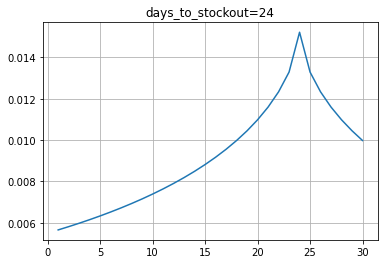

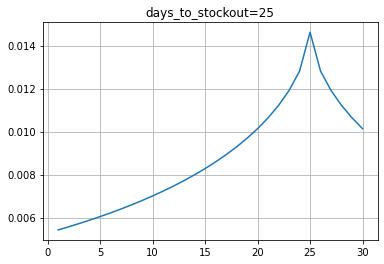

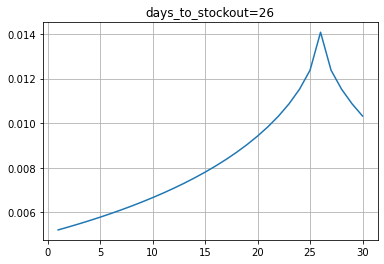

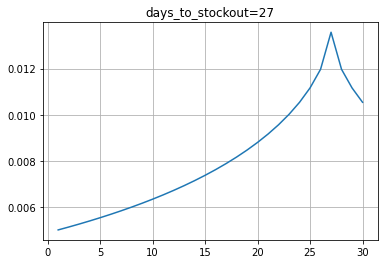

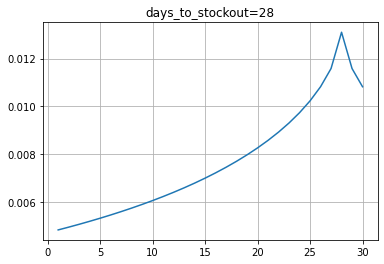

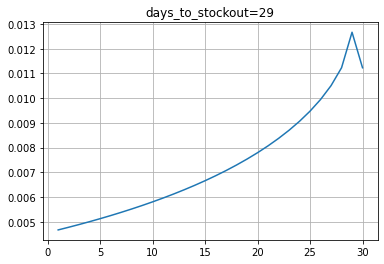

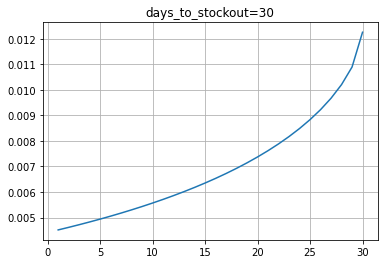

In [43]:
std_days = np.mean(np.asarray(list(predictor.parameters["std"].values())) / np.asarray(list(predictor.parameters["mean"].values())))

for days_to_stockout in range(1,31):
    scale = std_days * (dist_config["lambda1"]*(days_to_stockout**dist_config["lambda2"]))
    days = np.arange(1,31)
    probs = stats.gennorm.pdf(days, loc=days_to_stockout, scale=scale, beta=dist_config["beta"])
    
    plt.plot(days, probs)
    plt.grid()
    plt.title(f"days_to_stockout={days_to_stockout}")
    plt.show()

In [44]:
skus = list()
preds_proba = list()
groups = (
    test[["sku","target_stock"]]
    .drop_duplicates()
    .groupby("sku")
)

for sku,df in tqdm(groups):
    skus.append(sku)
    preds_proba.append(predictor.predict_proba(
        sku, 
        stock=df.target_stock.values[0],
        dist_kwargs={"beta":dist_config["beta"]},
        lambda1=dist_config["lambda1"], 
        lambda2=dist_config["lambda2"],
    ))
preds_proba = np.array(preds_proba)
preds_proba = pd.DataFrame(preds_proba, index=skus)

100%|██████████| 526189/526189 [02:35<00:00, 3381.45it/s]


In [45]:
unpreds_proba = np.ones((len(unpredictable),30)) / 30
unpreds_proba = pd.DataFrame(unpreds_proba, index=unpredictable.sku.values)

preds_proba_mrg = pd.concat([preds_proba, unpreds_proba])
preds_proba_mrg

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.054247,0.062126,0.073009,0.092308,0.078721,0.065857,0.057044,0.050306,0.044885,0.040386,0.036574,0.033296,0.030441,0.027934,0.025714,0.023735,0.021963,0.020367,0.018925,0.017616,0.016425,0.015337,0.014342,0.013428,0.012588,0.011813,0.011098,0.010437,0.009824,0.009255
1,0.020942,0.021442,0.021961,0.022500,0.023060,0.023643,0.024249,0.024882,0.025542,0.026231,0.026952,0.027708,0.028501,0.029335,0.030213,0.031140,0.032122,0.033163,0.034273,0.035459,0.036732,0.038107,0.039602,0.041241,0.043057,0.045102,0.047458,0.050274,0.053916,0.061192
2,0.025573,0.025934,0.026305,0.026686,0.027078,0.027482,0.027898,0.028328,0.028771,0.029229,0.029704,0.030195,0.030705,0.031235,0.031786,0.032362,0.032963,0.033593,0.034256,0.034954,0.035694,0.036481,0.037323,0.038232,0.039222,0.040317,0.041554,0.043000,0.044822,0.048319
3,0.022706,0.023627,0.024611,0.025667,0.026802,0.028030,0.029363,0.030821,0.032425,0.034208,0.036213,0.038509,0.041203,0.044503,0.048929,0.054502,0.047650,0.043598,0.040480,0.037900,0.035685,0.033741,0.032006,0.030441,0.029017,0.027712,0.026509,0.025394,0.024358,0.023390
5,0.021050,0.021548,0.022064,0.022600,0.023157,0.023736,0.024339,0.024967,0.025623,0.026307,0.027023,0.027773,0.028560,0.029386,0.030257,0.031176,0.032148,0.033180,0.034279,0.035452,0.036713,0.038073,0.039551,0.041170,0.042965,0.044984,0.047309,0.050087,0.053677,0.060843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393191,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
262125,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
393209,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
131068,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333


***
## generate submission

In [46]:
test = pd.read_csv(f"{input_path}/test_data.csv")
preds_proba_mrg = preds_proba_mrg.loc[test.sku.values,:].copy()

In [47]:
assert preds_proba_mrg.isna().sum(axis=1).sum() == 0
assert np.allclose(preds_proba_mrg.sum(axis=1).values, 1, atol=1e-16)
assert preds_proba_mrg.max(axis=1).max() < 1

In [48]:
(preds_proba_mrg
 .round(4)
 .to_csv(f"{subs_path}/sub{SUB_NBR}.csv.gz", header=False, index=False, compression="gzip")
)

***